# **Práctica 11 Módulo 3.4: Modelos Ensamblados - Random Forest**

En este ejercicio entrenaremos un modelo de Random Forest optimizando sus hiperparámetros para maximizar el rendimiento. Evaluaremos el modelo utilizando métricas como la precisión, la matriz de confusión y la curva ROC. También se analizará la importancia de las características y llevará a cabo una búsqued en cuadrícula (GrisSrearch) para encontrar los mejores hiperparámetros.

## **LIBRERÍAS Y CONFIGURACIÓN**

In [73]:
# Carga de datos
# =========================================================================================
from google.colab import files
import io

# Tratamientod de datos
# =========================================================================================
import numpy as np
import pandas as pd

# Preprocesado y Modelado
# =========================================================================================
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

# Gráficos
# ==========================================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

# Configuración de Gráficos
# ==========================================================================================
plt.rcParams['image.cmap'] = "bwr"
plt.rcParams['figure.dpi'] = "100"
plt.rcParams['savefig.bbox'] = "tight"
style.use('ggplot') or plt.style.use('ggplot')
sns.set_theme()

# Configuración Warnings
# ===========================================================================================
import warnings
warnings.filterwarnings('ignore')

## **FUNCIONES**

In [74]:
# =========================================================================================
# Carga de datos
# =========================================================================================
def carga_dataframe():
  """
  Función para cargar un DataFrame desde un archivo CSV
  :param path: Ruta del archivo CSV
  :return: DataFrame con los datos
  """

  # Abro una ventana para elegir el archivo
  uploaded = files.upload()

  # El archivo se sube directamente al entorno de colab actual
  # Obtenemos el nombre del archivo mediante la clave del directorio
  for filename in uploaded.keys():
    print(filename)
    print(f"✅ Archivo '{filename}' subido correctamente")

    # Cargamos el archivo usando su nombre en un dataframe
    # Manejamos la excepción por si el archivo no es un '.csv'
    try:
      # Si es un CSV cargará correctamente
      df = pd.read_csv(filename)
      print(f"\nPrimeras filas del DataFrame cargado: \n{df.head()}")
      # Devuelvo el dataframe
      return df
    except Exception as e:
      print(f"❌ Error al procesar el archivo:\n{e}")


# =========================================================================================
# Tratamientod de datos
# =========================================================================================
def get_dummies(df: pd.DataFrame, column: str):

  # Codificación de variable week con OneHot
  cat_feature = df[[column]]

  # Inicializo el OHE
  ohe = OneHotEncoder(
      handle_unknown=  'ignore',
      sparse_output=  False
  )

  # Ajustar y transformar los datos
  encoded_data = ohe.fit_transform(cat_feature)

  # Obtengo los nombres de las columnas
  feature_names = ohe.get_feature_names_out([column])

  # Convierto a DataFrame de Pandas
  encoded_df = pd.DataFrame(encoded_data, columns=feature_names)

  # Concateno los dos DataFrames
  df = pd.concat([df.drop(column, axis=1), encoded_df], axis=1)

  # Cambio el tipo de dato de las variables dummies a entero en vez de float64
  df[feature_names] = df[feature_names].astype(int)

  return df

# =========================================================================================
# EDA
# =========================================================================================
def analizar_data(data: pd.DataFrame, target: str):
  """
  Función para sacar un análisis exploratorio de los datos
  :param data: DataFrame con los datos
  :return: None
  """
  # Imprimimos por pantalla el conteo de filas y columnas con el tipo de dato de estas
  conteo_filas_columnas_tiposdato(data)

  # Imprimimos por pantalla las columnas que tengan nulos
  analizar_nulos(data)

  # Conteo de la variable target
  analizar_balance_target(data, target)

  # Finalmente sacamos un data.describe() para ver las estadísticas básicas
  print("\n📊 Análisis estadístico de los datos:")
  print(data.describe())
  print("\n")


def conteo_filas_columnas_tiposdato(data: pd.DataFrame):
  """
  Función para sacar el conteo de filas, columnas y tipos de dato de un DataFrame
  :param data: DataFrame con los datos
  :return: None
  """
  # Sacamos el número de filas, el de columnas
  print("Nº filas: " + str(data.shape[0]))
  print("Nº columnas: " + str(data.shape[1]))

  # Imprimimos por pantalla el nombre de las columnas y el tipo de dato que tienen
  print("\nNombre de columnas y tipo de dato de estas:")
  print(data.dtypes)


def analizar_nulos(data: pd.DataFrame):
  """
  Función para analizar los nulos de un DataFrame
  :param data: DataFrame con los datos
  :return: None
  """

  nulos = data.isnull().sum() # Cálculo de nulos
  ratio = (nulos/data.shape[0]) * 100 # Cálculo de ratios

  resumen = pd.DataFrame({
      'Nulos': nulos,
      'Ratio (%)': ratio
  })

  print("\n🗒️ Análisis de valores nulos:")
  print(resumen)

  print("\nNúmero de filas del DataFrame duplicadas:")
  print(data.duplicated().sum())


def analizar_balance_target(data: pd.DataFrame, target: str):
  """
  Función para analizar el balance de la variable target
  :param data: DataFrame con los datos
  :return: None
  """

  conteo = data[target].value_counts()
  ratio = (conteo/data.shape[0]) * 100

  resumen = pd.DataFrame({
      'Conteo': conteo,
      'Ratio': ratio
  })

  print("\n📊 Conteo y ratio de la variable target:")
  print(resumen)

# =========================================================================================
# Análisis gráfico de los datos
# =========================================================================================
def hist(df: pd.DataFrame, target: str):
  """
  Función para sacar un histograma de una variable
  :param df: DataFrame con los datos
  :param target: Variable a analizar
  :return: None
  """
  plt.figure(figsize=(8, 5))
  sns.histplot(df[target], kde=True, bins=20)
  plt.title(f'Distribución de {target}')
  plt.xlabel(target)
  plt.show()

def calc_rows_cols(num_features: int, max_cols: int = 4):
  """
  Función para calcular el número de filas y columnas para un gráfico
  :param num_features: Número de características
  :param max_cols: Número máximo de columnas
  :return: Número de filas y columnas
  """

  # Cálculo de número total de plots y filas necesarias
  rows = (num_features + max_cols - 1) // max_cols

  return max_cols, rows

def features_dist(df: pd.DataFrame, features: list):
  """
  Función para sacar boxplots de las características
  :param df: DataFrame con los datos
  :param features: Lista de variables a analizar
  :return: None
  """
  COLS, ROWS = calc_rows_cols(len(features))

  # Ajuste total de la fig
  plt.figure(figsize=(COLS * 5, ROWS * 5))
  for i, col in enumerate(features):
    # Calculo la posicion
    pos = i + 1
    # Creo el subplot
    plt.subplot(ROWS, COLS, pos)
    sns.boxplot(y=df[col])
    plt.title(f'Box Plot: {col}')
  plt.tight_layout()
  plt.show()

def relationship_disp(df: pd.DataFrame, target: str, features: list):
  """
  Función para sacar un diagrama de dispersión de una variable
  :param df: DataFrame con los datos
  :param target: Variable a analizar
  :param features: Lista de variables a analizar
  :return: None
  """

  COLS, ROWS = calc_rows_cols(len(features))

  # Ajuste total de la fig
  plt.figure(figsize=(5 * COLS, 5 * ROWS))

  for i, col in enumerate(features):
    # Calculo la posición actual
    pos = i + 1
    # Creo el subplot
    plt.subplot(ROWS, COLS, pos)
    sns.scatterplot(x=df[col], y=df[target])
    plt.title(f'{col} vs {target}')
  plt.tight_layout()
  plt.show()

def graph_analysis(df: pd.DataFrame, target: str, features: list):
  """
  Función para sacar un análisis gráfico de los datos
  :param df: DataFrame con los datos
  :param target: Variable a analizar
  :param features: Lista de variables a analizar
  :return: None
  """

  # Llamada la función del histograma
  hist(df, target)

  # Llamada a la función de boxplot de características
  features_dist(df, features)

  # Llamada la función de dispersion target vs features
  relationship_disp(df, target, features)

# =========================================================================================
# Análisis de correlación Pearson
# =========================================================================================
def corr_pearson(df: pd.DataFrame):
  """
  Función para sacar un análisis de correlación de Pearson
  :param df: DataFrame con los datos
  :param target: Variable a analizar
  :param features: Lista de variables a analizar
  :return: None
  """
  # Con llamar a la función de la matriz de correlacion dentro de la funcion del mapa de calor basta
  corr_heatmap(get_corr_matrix(df))

def get_corr_matrix(df: pd.DataFrame):
  """
  Función para sacar la matriz de correlación de Pearson
  :param df: DataFrame con los datos
  :return: Matriz de correlación de Pearson
  """
  corr_matrix = df.corr(method="pearson")

  print("\nMatriz de correlación de Pearson:")
  print(corr_matrix)

  return corr_matrix

def corr_heatmap(corr_matrix: pd.DataFrame):
  """
  Función para sacar por pantalla un mapa de calor de correlación
  :param df: DataFrame con los datos
  :param target: Variable a analizar
  :param features: Lista de variables a analizar
  :return: None
  """

  plt.figure(figsize=(7, 6))
  sns.heatmap(
      corr_matrix,
      annot= True,
      fmt= ".2f",
      cmap= "coolwarm",
      cbar=True,
      linewidth= 0.5,
      linecolor= "black"
  )
  plt.title("Mapa de calor de la correlación de Pearson")
  plt.show()

# =========================================================================================
# Análisis modelos de regresión
# =========================================================================================
def regressor_metrics(y_test, y_pred):
  # Calculamos las métricas de regresión
  mae = mean_absolute_error(y_test, y_pred)
  r2 = r2_score(y_test, y_pred)
  rmse = np.sqrt(mean_squared_error(y_test, y_pred))

  # Diccionario para almacenar las métricas
  metrics = {
      "r2": r2,
      "mae": mae,
      "rmse": rmse
  }

  print("Métricas del Modelo:")
  print(f"  R-cuadrado: {r2:.4f}")
  print(f"  Error Medio Absoluto: {mae:.4f}")
  print(f"  Raíz del Error Cuadrático Medio: {rmse:.4f}")
  print(f"  (Interpretación: R^2 indica qué porcentaje de la varianza es explicada por el modelo.)")
  print(f"  (Interpretación: MAE indica que, en promedio, el modelo se equivoca en {mae:.2f} grados al predecir la temperatura.)")

  return metrics

def regressor_graph_pred_vs_real(y_test, y_pred):
  print("Generando gráfico de Predicciones vs Reales...")

  plt.figure(figsize=(10,6))
  sns.scatterplot(
    x=      y_test,
    y=      y_pred,
  )
  # Línea de referencia
  plt.plot(
      [y_test.min(), y_test.max()],
      [y_test.min(), y_test.max()],
      "r--",
      lw= 2
  )
  plt.title("Modelo Base: Valores Reales vs Predicciones")
  plt.xlabel("Valores Reales")
  plt.ylabel("Predicciones")
  plt.show()

# =========================================================================================
# Importancia de características
# =========================================================================================
def get_feature_importance(model, features):
  print("\nExtrayendo importancia de características...")
  importances = model.feature_importances_

  # Creo un DF para visualizar mejor
  df_importances = pd.DataFrame({
      "Feature": features,
      "Importance": importances
  }).sort_values(by="Importance", ascending=False) # los ordeno de mayor a menor

  print("Importancia de las características (Top 10):")
  print(df_importances.head(10))

  # Gráfico de importancia
  plt.figure(figsize=(10, 6))
  sns.barplot(
    x=    "Importance",
    y=    "Feature",
    data= df_importances.head(15)
  )

  plt.title("Importancia de las Características (Random Forest Base)")
  plt.xlabel("Importancia")
  plt.ylabel("Característica")
  plt.show()

  return df_importances

# =========================================================================================
# Tuning de Hiperparámetros
# =========================================================================================
def grid_search(model, param_grid: dict, X_train, y_train, scoring: str):
  print("Iniciando Búsqueda en Cuadrícula...")

  # Inicializar GridSearchCV, con CV-5 pliegues
  grid_search = GridSearchCV(
      estimator=  model,
      param_grid= param_grid,
      cv=         5,
      scoring=    'neg_mean_absolute_error',
      n_jobs=     1,
      verbose=    1
  )

  # Ajustar el Grid Search a los datos de entrenamiento
  grid_search.fit(X_train, y_train)

  # Obtener los mejores hiperparámetros
  print("\n¡Búsqueda completada!")
  print(f"Mejores hiperparámetros encontrados: {grid_search.best_params_}")
  print(f"Mejor MAE (negativo) en CrossVal: {grid_search.best_score_:.4f}")

  # Devuelvo el mejor modelo
  return grid_search.best_estimator_

## **1. Carga de datos y EDA**

### **Carga del CSV de datos a través de Google Drive**

In [75]:
# Defino la ruta base y el nombre del archivo
FILE_NAME = "temps.csv"
BASE_PATH = "C:/Users/Adrian/Desktop"

In [76]:
# Utilizo la función definida arriba para traerme el CSV desde la ruta a su ubicación a Colab
df = carga_dataframe()

Saving temps.csv to temps (2).csv
temps (2).csv
✅ Archivo 'temps (2).csv' subido correctamente

Primeras filas del DataFrame cargado: 
   year  month  day  week  temp_2  temp_1  average  actual  forecast_noaa  \
0  2016      1    1   Fri      45      45     45.6      45             43   
1  2016      1    2   Sat      44      45     45.7      44             41   
2  2016      1    3   Sun      45      44     45.8      41             43   
3  2016      1    4   Mon      44      41     45.9      40             44   
4  2016      1    5  Tues      41      40     46.0      44             46   

   forecast_acc  forecast_under  friend  
0            50              44      29  
1            50              44      61  
2            46              47      56  
3            48              46      53  
4            46              46      41  


Echando un vistazo a los datos puedo deducir que es un dataset de temperaturas, en el cual el objetivo es predecir la temperatura máxima real de algo.

Así pues nuestra variable objetivo será `actual`.

### **EDA y preprocesamiento de los datos**

Antes de hacer nada vemos que la columna week, que es el día de la semana está codificada como strings. Para ser un poco más profesionales, en vez de codificarla con números del 1 al 7, para no introducir ningún tipo de sesgo al modelo del estilo que piense que el domingo por ser 7 es más grande que el lunes por ser 1 usaremos ´OneHotEncoding´.

In [77]:
# Llamo a la función
df = get_dummies(df, 'week')
# Compruebo que todo está correcto
df.head()

,year,month,day,temp_2,temp_1,average,actual,forecast_noaa,forecast_acc,forecast_under,friend,week_Fri,week_Mon,week_Sat,week_Sun,week_Thurs,week_Tues,week_Wed
0,2016,1,1,45,45,45.6,45,43,50,44,29,1,0,0,0,0,0,0
1,2016,1,2,44,45,45.7,44,41,50,44,61,0,0,1,0,0,0,0
2,2016,1,3,45,44,45.8,41,43,46,47,56,0,0,0,1,0,0,0
3,2016,1,4,44,41,45.9,40,44,48,46,53,0,1,0,0,0,0,0
4,2016,1,5,41,40,46.0,44,46,46,46,41,0,0,0,0,0,1,0


Antes de nada, la columna year, me da que el DataFrame solo tiene datos de un año en concreto. Voy a comprobar esta hipótesis y si es cierta eliminaré esta columna ya que será irrelevante para nuestro modelo.

In [78]:
# Compruebo los valores de la columna year
print(df['year'].value_counts())

year
2016    348
Name: count, dtype: int64


In [79]:
# Como efectivamente solo tiene información de 2016 paso a eliminar esta columna de los datos ya que es irrelevante para nuestro modelo
df = df.drop('year', axis=1)

In [80]:
# Separo la variable target del resto de caracteristicas
TARGET_COL = "actual"
FEATURE_COLS = [col for col in df.columns if col != TARGET_COL]

# Creo una lista de las caracteristicas sin las características dummies para graficado
prefix_dummy = 'week_'

# Filtro la lista para exclir ls columnas dummy
FEATURE_COLS_NO_DUMMIES = [col for col in FEATURE_COLS if not col.startswith(prefix_dummy)]

In [81]:
# Llamo a la función de análisis
analizar_data(df, TARGET_COL)

Nº filas: 348
Nº columnas: 17

Nombre de columnas y tipo de dato de estas:
month               int64
day                 int64
temp_2              int64
temp_1              int64
average           float64
actual              int64
forecast_noaa       int64
forecast_acc        int64
forecast_under      int64
friend              int64
week_Fri            int64
week_Mon            int64
week_Sat            int64
week_Sun            int64
week_Thurs          int64
week_Tues           int64
week_Wed            int64
dtype: object

🗒️ Análisis de valores nulos:
                Nulos  Ratio (%)
month               0        0.0
day                 0        0.0
temp_2              0        0.0
temp_1              0        0.0
average             0        0.0
actual              0        0.0
forecast_noaa       0        0.0
forecast_acc        0        0.0
forecast_under      0        0.0
friend              0        0.0
week_Fri            0        0.0
week_Mon            0        0.0
week_Sat 

### **Análisis gráfico de los datos**

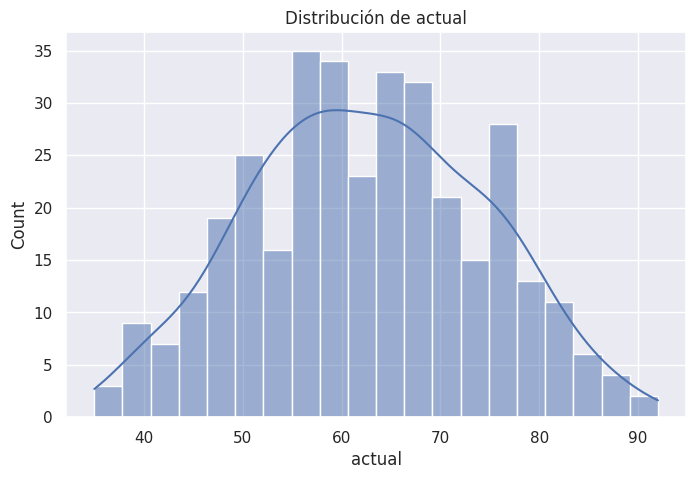

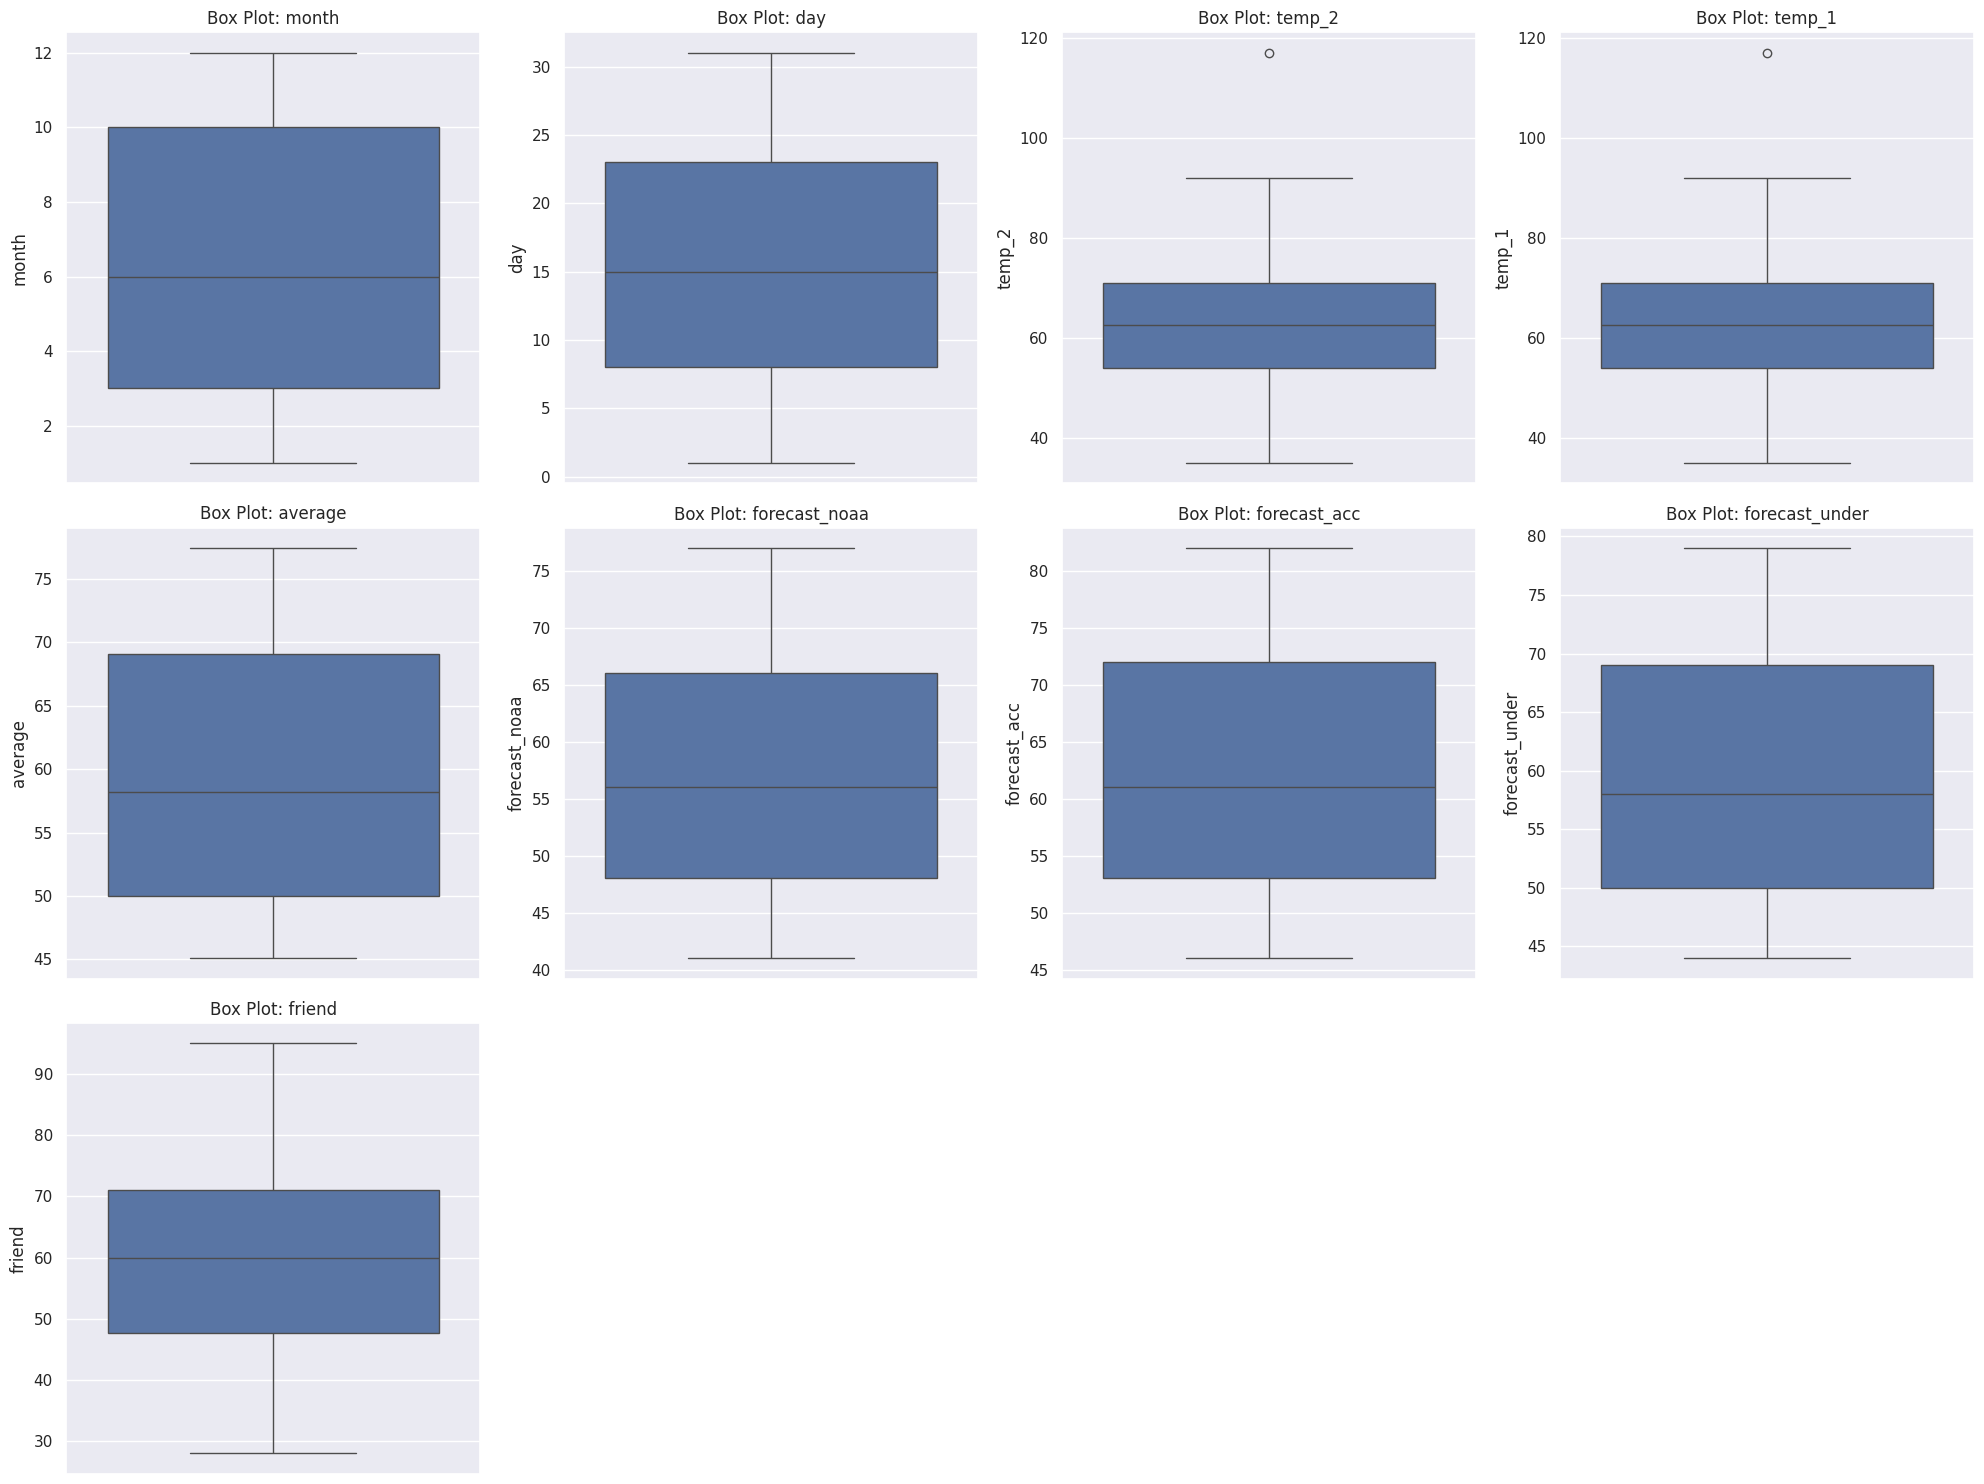

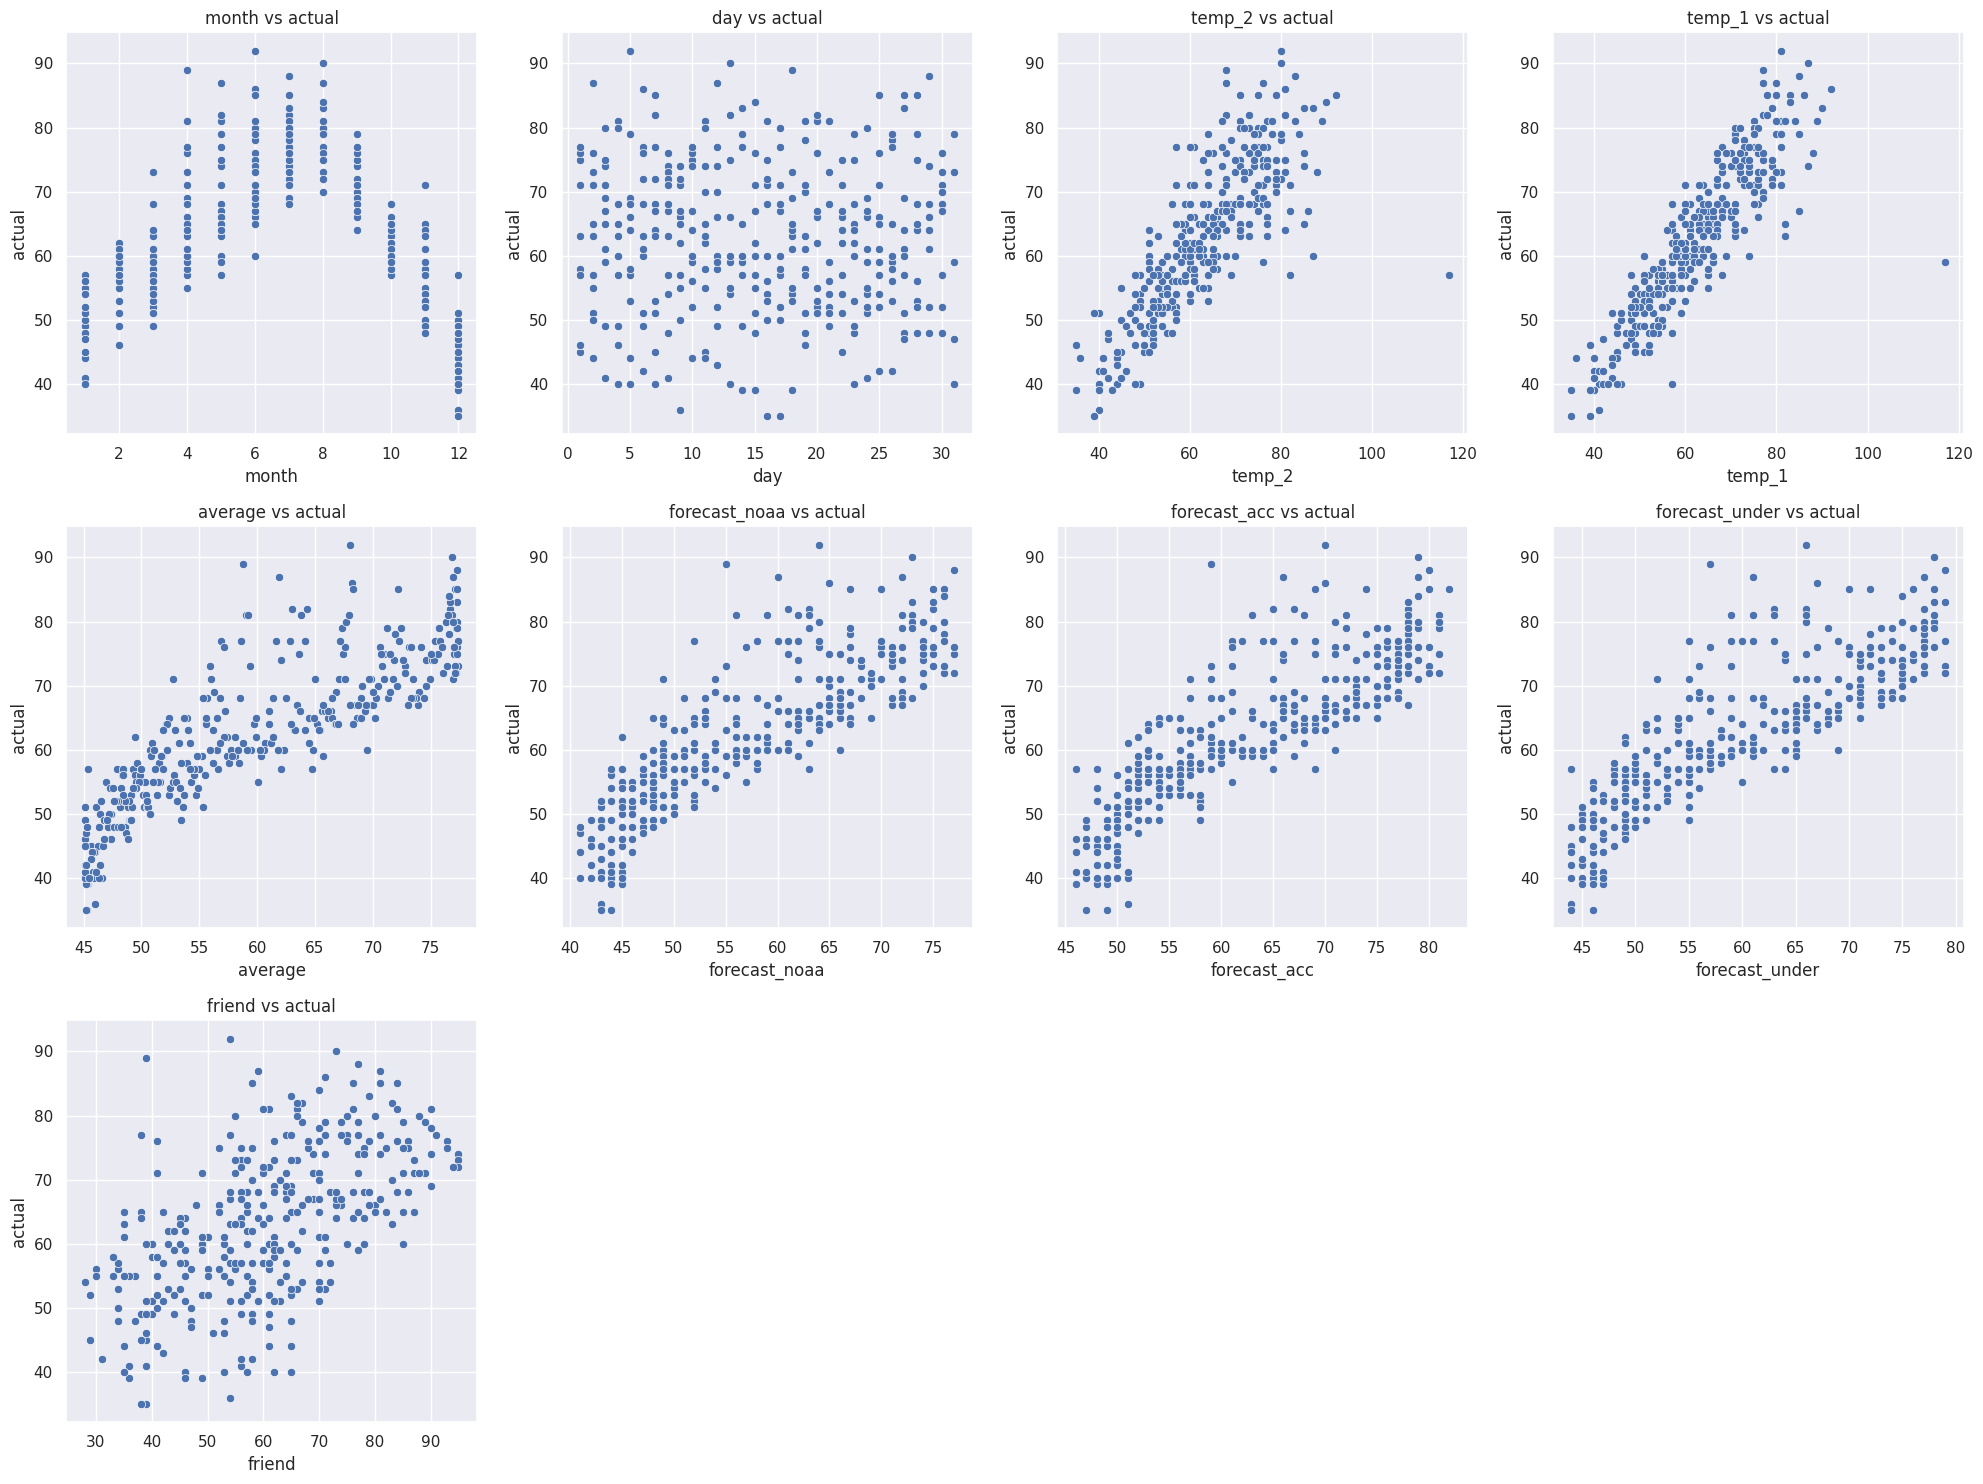

In [82]:
# Llamo a la función general del análisis gráfico
graph_analysis(df, TARGET_COL, FEATURE_COLS_NO_DUMMIES)

Las primeras conclusiones que podemos sacar de los gráficos es que:

- La variable objetivo sigue la forma de una distribución normal bastante marcada.

- Si nos fijamos en los boxplot de las características estas tambíen siguen la distribución normal, con algún outlier en features como *temp_1* y *temp_2*.

- En cuanto a la relación que tiene *actual* con las características podemos afirmar que, en general, tienen una relación lineal. A excepción de las features categóricas o *friend*.


### **Análisis de Correlación (Pearson)**

Veamos ahora la correlación de Pearson de las columnas.


Matriz de correlación de Pearson:
                   month       day    temp_2    temp_1   average    actual  \
month           1.000000 -0.000412  0.047651  0.032664  0.120806  0.004529   
day            -0.000412  1.000000 -0.046194 -0.000691 -0.021136 -0.021675   
temp_2          0.047651 -0.046194  1.000000  0.857800  0.821560  0.805835   
temp_1          0.032664 -0.000691  0.857800  1.000000  0.819328  0.877880   
average         0.120806 -0.021136  0.821560  0.819328  1.000000  0.848365   
actual          0.004529 -0.021675  0.805835  0.877880  0.848365  1.000000   
forecast_noaa   0.131141 -0.021393  0.813134  0.810672  0.990340  0.838639   
forecast_acc    0.127436 -0.030605  0.817374  0.815162  0.990705  0.842135   
forecast_under  0.119786 -0.013727  0.819576  0.815943  0.994373  0.838946   
friend          0.048145  0.024592  0.583758  0.541282  0.689278  0.569145   

                forecast_noaa  forecast_acc  forecast_under    friend  
month                0.131141     

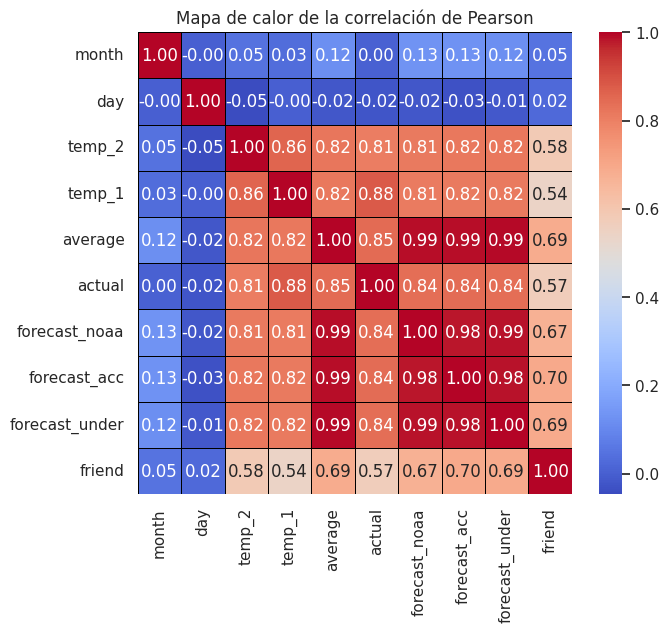

In [83]:
aux_cols = [col for col in df.columns if not col.startswith("week")]
corr_df = df[aux_cols] # selecciono las columnas que me interesan

# Llamamos a la función de la correlación
corr_pearson(corr_df)

Vemos que *actual* tiene valores de correlación altos con todas las variables que tienen que ver con temperaturas o predicciones del tiempo (lógico en series de tiempo o meteorológicos). Sin embargo tiene correlación prácticamente nula con las variables que tienen que ver con el día del mes o el mes en el que se encuentra, lo cual es esperado porque la temperatura no depende del día del mes, el propio mes o el día de la semana.

También podemos ver que tenemos problemas de multicolinealidad entre carácterísticas. También es lógico porque es entre características similares (temperaturas 1 y 2, predicciones meteorológicas semejantes,...).

*Friend* es una característica única que, a pesar de no tener una fuerte correlación con la variable objetivo (0.57), podría capturar información interesante por esto mismo.

Si estuviésemos trabajando con modelos de regresión lineal o logística, esta multicolinealidad podría suponer un problema grave. Sin embargo, al trabajar con *Random Forest* **no es un problema tan grave** y a menudo se ignora.



### **Decisión sobre variables temporales**

Aunque haya generado las variables dummy para la característica *week* voy a tomar la decisión de eliminarlas. Tanto estas variables dummy como la propia feature *week* y la feature del día del mes.

No obstante voy a mantener la característica *month*. El por qué detras de esta decisión es porque esta característica captura la estacionalidad de las temperaturas, esto quiere decir que, me parece interesante que el modelo sepa que en los meses de invierno las temperaturas son más bajas que en los meses de verano.

Voy a seguir el mismo método que seguí con la característica *week* para la columna *month* de generar las variables dummy, ya que me parece una práctica más profesional y así no damos pie al modelo a pensar que hay un orden en estos meses.

In [84]:
# Elimino características que hablan del día del mes, mes o día de la semana en la que nos encontramos por no aportar nada al modelo
col_to_delete = [col for col in df.columns if col.startswith('week')] + ['day'] # selecciono columnas

# Elimino las columnas del dataframe
df = df.drop(col_to_delete, axis=1)

In [85]:
# Creación de variables dummy con la función de antes
df = get_dummies(df, 'month')

# Actualizo las constantes de características y target
TARGET_COL = "actual"
FEATURE_COLS = [col for col in df.columns if col != TARGET_COL]

# Comprobación del proceso
df.head()

,temp_2,temp_1,average,actual,forecast_noaa,forecast_acc,forecast_under,friend,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,45,45,45.6,45,43,50,44,29,1,0,0,0,0,0,0,0,0,0,0,0
1,44,45,45.7,44,41,50,44,61,1,0,0,0,0,0,0,0,0,0,0,0
2,45,44,45.8,41,43,46,47,56,1,0,0,0,0,0,0,0,0,0,0,0
3,44,41,45.9,40,44,48,46,53,1,0,0,0,0,0,0,0,0,0,0,0
4,41,40,46.0,44,46,46,46,41,1,0,0,0,0,0,0,0,0,0,0,0


## **2. Entrenamiento del Modelo**

En este bloque entrenaremos el modelo base de RandomForest.

### **División de los Datos (Entrenamiento y Prueba)**

Escogeremos una división típica de 80/20 para este caso por la cantidad de entradas que tenemos.

In [86]:
# División entre target y características
X = df[FEATURE_COLS]
y = df[TARGET_COL]

# División de los datos en train y test
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=    0.2,
    random_state= 1234
)

print(f"Datos de entrenamiento: {X_train.shape[0]} muestras.")
print(f"Datos de prueba: {X_test.shape[0]} muestras.")

Datos de entrenamiento: 278 muestras.
Datos de prueba: 70 muestras.


### **Entrenamiento del Modelo Base**

In [87]:
print("Entrenando el modelo base de Random Forest...")

# Instancio el modelo
rf_base = RandomForestRegressor(
    n_estimators=   100,
    max_depth=      5,
    random_state=   1234
)

# Entreno el modelo
rf_base.fit(X_train, y_train)

# Predecimos sobre el conjunto de prueba
y_pred_base = rf_base.predict(X_test)

print("Entrenamiento Satisfactorio.")

Entrenando el modelo base de Random Forest...
Entrenamiento Satisfactorio.


### **Métricas del Modelo Base**

Escogeremos como métricas:

 - **R-cuadrado**: Mide la "Calidad" del ajuste mediante el porcentaje de variabilidad de la temperatura real (actual). Cuánto mayor es, mejor estará prediciendo el modelo.

 - **MAE(Error Medio Absoluto)**: Mide la "Interpretabilidad" mediante el promedio de cuánto de lejos están tus predicciones del valor real. Responde a la pregunta "Cuánto se equivoca el modelo", cuanto menor es menos se equivoca el modelo.

 - **RMSE (Raíz del Error Cuadrático Medio)**: Mide la "Penalización". Es similar al MAE pero al ser la raíz cuadrada, penaliza mucho más los errores graves.

In [88]:
# Llamo a la función que realiza esta tarea
base_metrics = regressor_metrics(y_test, y_pred_base)

Métricas del Modelo:
  R-cuadrado: 0.7945
  Error Medio Absoluto: 3.8986
  Raíz del Error Cuadrático Medio: 5.1066
  (Interpretación: R^2 indica qué porcentaje de la varianza es explicada por el modelo.)
  (Interpretación: MAE indica que, en promedio, el modelo se equivoca en 3.90 grados al predecir la temperatura.)


### **Visualización: Predicciones vs Valores Reales**

Generando gráfico de Predicciones vs Reales...


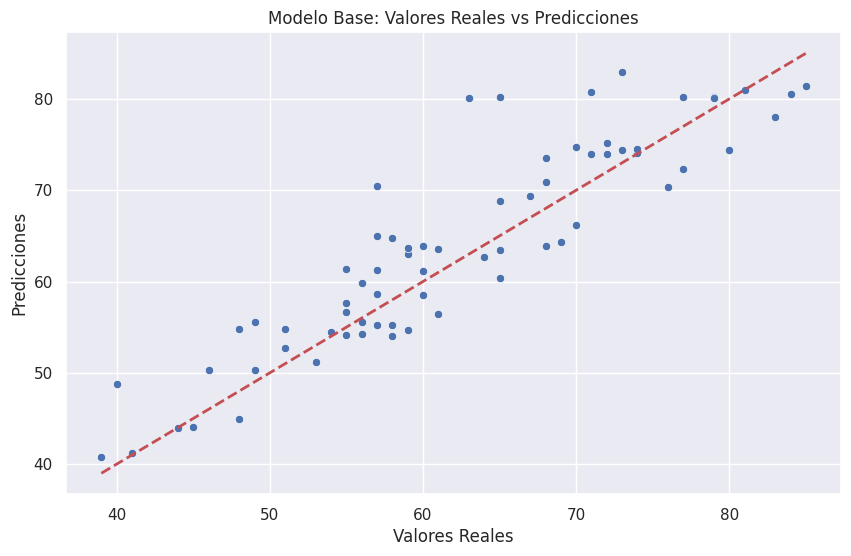

In [89]:
# Llamo a la función que realiza esta tarea
regressor_graph_pred_vs_real(
    y_test= y_test,
  	y_pred= y_pred
)

Gracias a esta gráfica vemos que el modelo ajusta bastante bien las predicciones. No se aprecia un gran sobreajuste en este.

### **Extracción y Visualización de Importancia de Características**


Extrayendo importancia de características...
Importancia de las características (Top 10):
           Feature  Importance
1           temp_1    0.470611
2          average    0.333084
4     forecast_acc    0.116468
3    forecast_noaa    0.038961
6           friend    0.014075
0           temp_2    0.012478
5   forecast_under    0.006983
15         month_9    0.002059
16        month_10    0.001364
11         month_5    0.001232


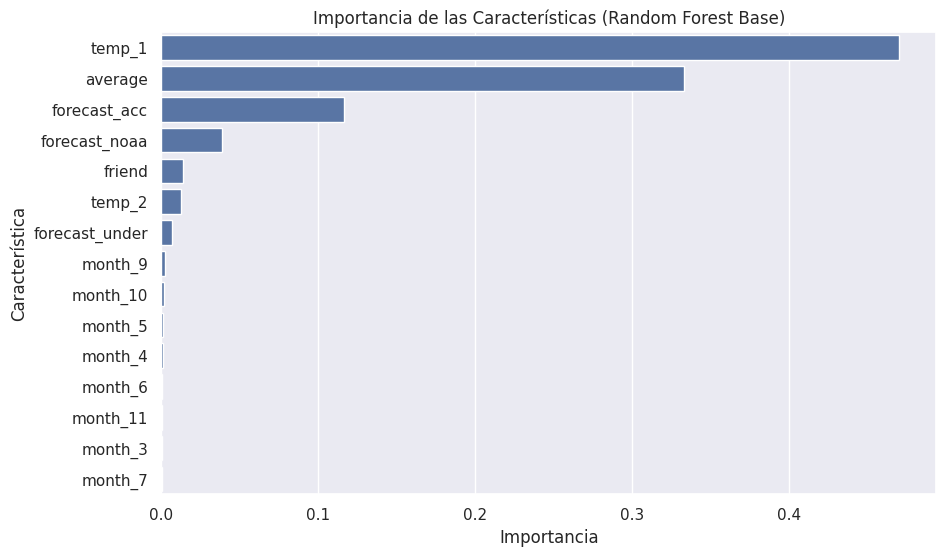

In [90]:
importances = get_feature_importance(
    model=    rf_base,
    features= FEATURE_COLS
)

Vemos que con gran diferencia las características que más aportan al modelo son *temp_1*, *average* y *forecast_acc*. Esto tiene sentido ya que son una característica sobre un tema de cada, el resto el modelo las considera redundantes.

## **3. Optimización del Modelo**

Vamos a optimizar nuestro modelo mediante GridSearchCV para encontrar los mejores hiperparámetros.


### **Búsqueda en Cuadrícula (GridSearchCV)**

En este caso de Random Forest los hiperparámetros más interesantes que podemos ajustar son:
- *n_estimators* (Número de árboles)
- *max_depth* (Profundidad máxima)
- *max_features* (Número de características a considerar)
- *min_samples_leaf* (Mínimo de muestras en un nodo)

In [91]:
# Definir la cuadrícula
param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 10, 20],
    'max_features': ['auto', 'sqrt', 'log2', 1.0],
    'min_samples_leaf': [1, 2, 4]
}

# Inicializar el RandomForestRegressor
rf_grid = RandomForestRegressor(random_state=1234)

# Llamo a la función del GridSearch
best_model = grid_search(
  model=      rf_grid,
  param_grid=  param_grid,
  X_train=    X_train,
  y_train=    y_train,
  scoring=    'neg_mean_absolute_error'
)

Iniciando Búsqueda en Cuadrícula...
Fitting 5 folds for each of 144 candidates, totalling 720 fits

¡Búsqueda completada!
Mejores hiperparámetros encontrados: {'max_depth': None, 'max_features': 1.0, 'min_samples_leaf': 4, 'n_estimators': 200}
Mejor MAE (negativo) en CrossVal: -3.8662


In [92]:
# Realizamos predicciones con el modelo optimizado
y_pred_tuned = best_model.predict(X_test)

### **Métricas del Modelo Optimizado y Comparación con Modelo Base**

In [93]:
print("\n================================== \t\tMétricas Modelo Optimizado\t\t ==================================")
# Llamamos a la función de las métricas
tuned_model_metrics = regressor_metrics(
  y_test= y_test,
  y_pred= y_pred_tuned
)

print("\n================================== \t\tMétricas Modelo Base\t\t ==================================")
regressor_metrics(
    y_test= y_test,
    y_pred= y_pred_base
)


================================== 		Métricas Modelo Optimizado		 ==================================
Métricas del Modelo:
  R-cuadrado: 0.7942
  Error Medio Absoluto: 3.8847
  Raíz del Error Cuadrático Medio: 5.1099
  (Interpretación: R^2 indica qué porcentaje de la varianza es explicada por el modelo.)
  (Interpretación: MAE indica que, en promedio, el modelo se equivoca en 3.88 grados al predecir la temperatura.)

================================== 		Métricas Modelo Base		 ==================================
Métricas del Modelo:
  R-cuadrado: 0.7945
  Error Medio Absoluto: 3.8986
  Raíz del Error Cuadrático Medio: 5.1066
  (Interpretación: R^2 indica qué porcentaje de la varianza es explicada por el modelo.)
  (Interpretación: MAE indica que, en promedio, el modelo se equivoca en 3.90 grados al predecir la temperatura.)


{'r2': 0.7945100247984795,
 'mae': 3.8985701969453137,
 'rmse': np.float64(5.106610877180281)}

#### **Interpretación de los resultados**

La primera conclusión que se saca es que no ha habido mejora significativa en la optimización del modelo, las métricas son prácticamente idénticas:

- **MAE**: Mejoró (bajó) en 0.0139 grados.
- **RMSE**: Empeoró (subió) en 0.0033 grados.
- **MAE**: Empeoró (bajó) en 0.0003.

Podríamos decir que, con las *features* que tenemos, un r-cuadrado de 0.794 (explicar el 79.4% de la varianza) y un MAE de aproximadamente 3.9 sea el **máximo rendimiento posible** que se puede extraer. Ningún ajuste de hiperparámetros puede crear información que no existe en las columnas.

En conclusión, me quedaría con el **modelo base**, ya que es un modelo más simle, más rápido de entrenar y que ofrece exactamente el mismo rendimiento predictivo que el modelo "optimizado". Siempre vamos a preferir un modelo más simple si el rendimiento es el mismo.

### **Visualización: Predicciones vs Reales (Modelo Optimizado)**

Generando gráfico de Predicciones vs Reales...


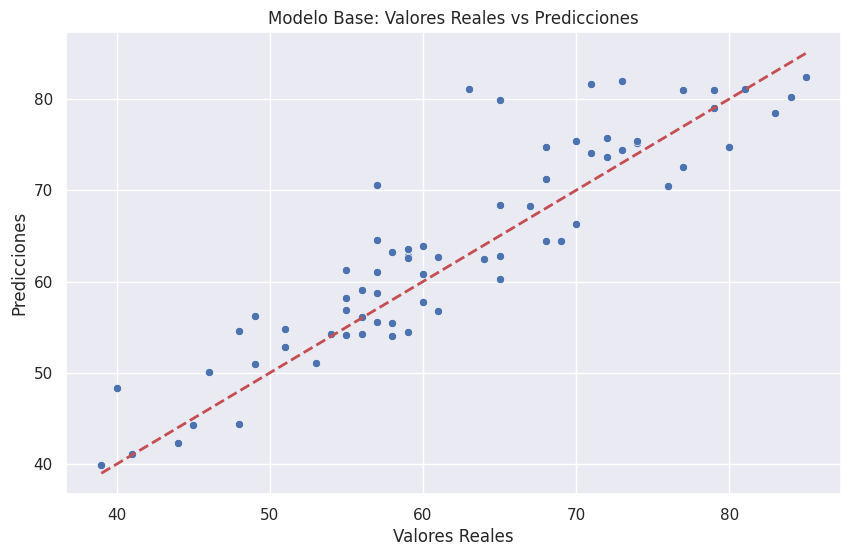

In [94]:
# Llamo a la función de esta visualización
regressor_graph_pred_vs_real(
  y_test= y_test,
  y_pred= y_pred_tuned
)

## **4. Discusión Teórica**

### **¿Cómo la aleatoriedad y el uso de múltiples árboles mejoran el rendimiento y la generalización?**

El Random Forest (Bosque Aleatorio) basa su éxito  en dos conceptos clave que mejoran drásticamente el rendimiento sobre un solo árbol:

1. **Múltiples Árboles (Método Ensamblado)**: El modelo no entrena un solo árbol de decisión, sino cientos de ellos (definidos por `n_estimators`). Para tomar una decisión final (en regresión), el modelo **promedia las predicciones** de todos los árboles individuales. Esto es como pedir la opinión a 100 expertos en lugar de a uno solo; el promedio de sus respuestas suele ser más preciso y estable que una solo opinión, que podría ser sesgada o errónea.

2. **La Aleatoriedad (Descorrelación)**: Para que este "comité de expertos" funcione, cada árbol debe ser diferente y haber aprendido de forma ligeramente distinta. Random Forest introduce aleatoriedad de dos maneras:

    * Aleatoriedad en las Filas (Bagging): Cada árbol se entrena en una sub-muestra aleatoria de los datos de entrenamiento (creada con reemplazo). Esto significa que ningún árbol ve exactamente el mismo conjunto de datos.

    * Aleatoriedad en las Columnas (Feature Randomness): Al decidir cómo hacer un corte (split) en un nodo, el árbol no evalúa todas las features (columnas). Solo evalúa un subconjunto aleatorio de ellas (definido por `max_features`). Esto fuerza a los árboles a encontrar diferentes patrones y evita que todos dependan de la misma feature súper-predictiva (como `temp_1` en tu caso).

La doble aleatoriedad crea cientos de árboles "descorrelacionados". Al promediar sus predicciones, se mejora la generalización porque los errores o sesgos específicos de un árbol se cancelan con los errores de otros, resultando en una predicción final más robusta.

### **Ventajas del Random Forest frente a un único Árbol de Decisión (Reducción del sobreajuste)**

La principal ventaja del Random Forest sobre un Árbol de Decisión único es la **drástica reducción del sobreajuste (overfitting)**.

Un **Árbol de Decisión único** (especialmente si es muy profundo, como `max_depth=None`) tiene una tendencia muy alta a **sobreajustarse**. Esto significa que "memoriza" perfectamente los datos de entrenamiento, aprendiendo todas sus peculiaridades y ruido. Cuando se enfrenta a datos nuevos (el conjunto de prueba), su rendimiento es muy pobre porque el ruido que memorizó no existe en los datos nuevos.

El **Random Forest** soluciona esto gracias al **promediado del ensemble** (descrito en el punto anterior):

- **Reducción de la Varianza**: Un solo árbol es un modelo de "alta varianza": un pequeño cambio en los datos de entrenamiento puede resultar en un árbol completamente diferente y predicciones muy distintas.

- **Estabilidad**: Al promediar las predicciones de cientos de árboles (cada uno entrenado en datos ligeramente diferentes), la predicción final se vuelve muy estable. El ruido o las peculiaridades de una pequeña parte de los datos (que afectarían a un solo árbol) se "diluyen" en el promedio del bosque, y solo los patrones robustos y generales persisten.

En resumen, mientras que un solo árbol memoriza el ruido, un bosque de árboles **aprende la clave de los datos**, reduciendo la varianza y logrando un modelo que generaliza mucho mejor a datos nunca vistos.